In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import helper

In [12]:

training = "traffic-signs-data/train.p"
testing = "traffic-signs-data/test.p"


with open(training, mode='rb') as file:
    train = pickle.load(file) 

with open(testing, mode='rb') as file:
    test = pickle.load(file)

In [13]:
X_tr, Y_tr = train['features'], train['labels']
X_te, Y_te = test['features'], test['labels']
classes = len(set(Y_tr))


print ("Training iputs shape: {}".format(X_tr.shape))
print ("Training labels shape: {}".format(Y_tr.shape))

print ("Testing iputs shape: {}".format(X_te.shape))
print ("Testing labels shape: {}".format(Y_te.shape))
print ("Number of classes {}". format(classes))

Training iputs shape: (39209, 32, 32, 3)
Training labels shape: (39209,)
Testing iputs shape: (12630, 32, 32, 3)
Testing labels shape: (12630,)
Number of classes 43


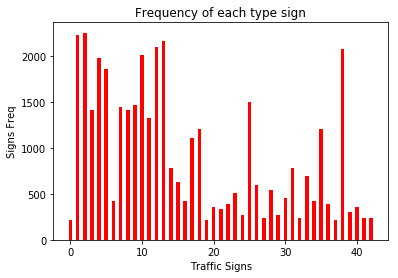

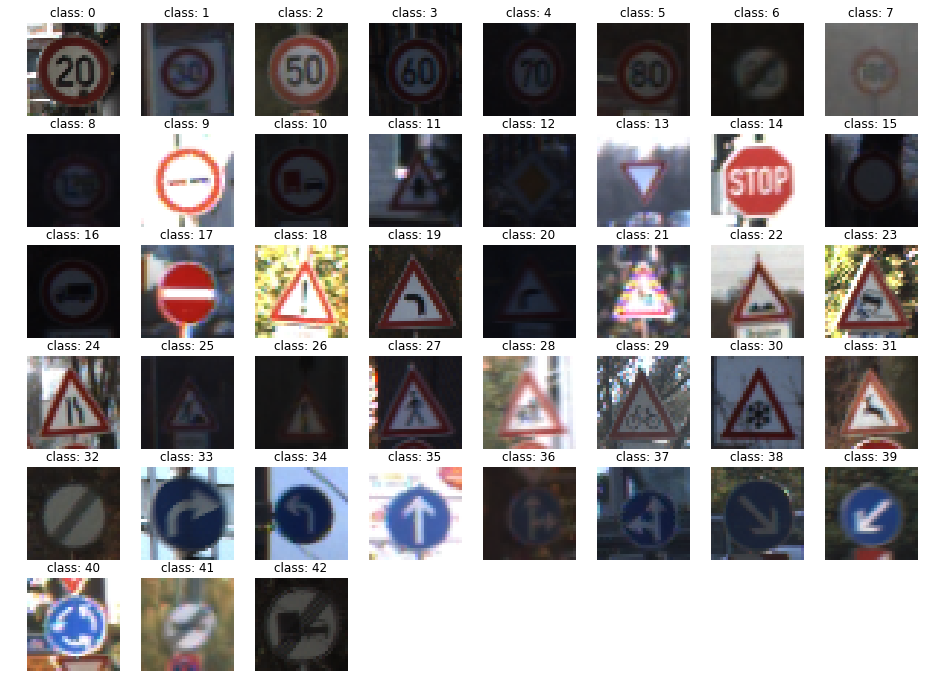

In [14]:
import random as rd

fig, ax = plt.subplots()
ax.bar(range(classes), np.bincount(Y_tr), 0.5, color='r')
ax.set_xlabel('Traffic Signs')
ax.set_ylabel('Signs Freq')
ax.set_title('Frequency of each type sign')
plt.show()

plt.figure(figsize=(16, 16))
for i in range(classes):
    j = rd.choice(np.where(Y_tr == i)[0])
    plt.subplot(8, 8, i + 1)
    plt.axis('off')
    plt.title('class: {}'.format(i))
    plt.imshow(X_tr[j])

In [83]:
tf.reset_default_graph()
sess = tf.Session()


In [84]:
def stats(X_batch, Y_batch):
    total_loss = 0
    total_acc = 0
    samples = len(X_batch)
    X_batch = np.reshape(X_batch, [-1, n_steps, n_inputs])
    sess = tf.get_default_session()
    for offset in range(0, samples, batch_size):
        end = offset+batch_size
        xs_batch, ys_batch = X_batch[offset:end], Y_batch[offset:end]
        loss_, acc = sess.run([loss, accuracy], feed_dict={x:xs_batch, 
                                                           y:ys_batch,
                                                           keep_prob: 1.0})
        total_loss += (float(loss_)*xs_batch.shape[0])
        total_acc += (float(acc)*xs_batch.shape[0])

    return (total_loss)/samples, (total_acc)/samples

In [85]:
def RNN(x_, w, b):
    x_ = tf.transpose(x_, [1, 0, 2])
    x_ = tf.reshape(x_, [-1, n_inputs])
    
    
    hidden = tf.matmul(x_, w['hidden']) + b['hidden']
    hidden = tf.nn.relu(hidden)
    hidden = tf.split(hidden, n_steps, 0)
    rnn_layers = [tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(n_hidden), output_keep_prob=keep_prob) for _ in range(n_layers)]
    rnn_layers = tf.contrib.rnn.MultiRNNCell(rnn_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(rnn_layers, hidden, dtype=tf.float32)
    
    rnn_output = outputs[-1]
    return tf.matmul(rnn_output, w['out']) + b['out']
    
    
    

In [86]:
learning_rate = 1e-3
n_steps = 32 
n_inputs = 32 * 3

n_layers = 2
n_hidden = 128
n_classes = classes
batch_size = 128

w = {
    'hidden': tf.Variable(tf.random_normal([n_inputs, n_hidden])),
    'out'   : tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
b = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out'  : tf.Variable(tf.random_normal([n_classes]))
}


x = tf.placeholder(dtype=tf.float32, shape=[None, n_steps, n_inputs])
y = tf.placeholder(dtype=tf.int32, shape=[None])

y_hot = tf.one_hot(y, classes)
keep_prob = tf.placeholder(dtype=tf.float32)


In [87]:
logits = RNN(x, w, b)

In [88]:
softmax = tf.nn.softmax(logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_hot))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

prediction = tf.equal(tf.argmax(softmax, 1), tf.argmax(y_hot, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

In [89]:
init = tf.global_variables_initializer()
sess.run(init)

In [90]:

from sklearn.utils import shuffle

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_loss_ = []
test_acc_ = []
epochs = 1000
samples = len(X_tr)


print("Initializing Training")
try:
    with tf.Session() as sess:
        for epoch in range(epochs):
            X_tr, Y_tr = shuffle(X_tr, Y_tr)
            for offset in range(0, samples, batch_size):
                end = offset+batch_size
                
                xs_batch, ys_batch = X_tr[offset:end], Y_tr[offset:end]
                xs_batch = np.reshape(xs_batch, [batch_size, n_steps, n_inputs])
                loss_, _, acc_ = sess.run([loss, optimizer, accuracy], feed_dict={x: xs_batch, 
                                                                                  y: ys_batch,
                                                                                  keep_prob: 0.8})
                train_loss.append(loss_)
                train_acc.append(acc_)
            validation_loss, validation_acc = train(X_train, Y_train)
            val_loss.append(validation_loss)
            val_acc.append(validation_acc)
            print("EPOCH {}".format(epoch + 1))
            print ("Validation Loss = {:.3f} and Validation Accuracy = {:.3f} %".format(validation_loss, 100 *validation_acc))
        test_loss, test_acc = train(X_te, Y_te)
        test_loss_.append(test_loss)
        test_acc_.append(test_acc)
        print ("Test Loss {} and Test Accuracy {:.3f} %".format(test_loss, 100 *test_acc))
except KeyboardInterrupt:
    print('Training interrupted')

Initializing Training


FailedPreconditionError: Attempting to use uninitialized value beta1_power
	 [[Node: beta1_power/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](beta1_power)]]

Caused by op 'beta1_power/read', defined at:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-88-b27e801296ca>", line 4, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 353, in minimize
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 474, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 130, in _create_slots
    trainable=False)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1927, in variable
    caching_device=caching_device, name=name, dtype=dtype)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta1_power
	 [[Node: beta1_power/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](beta1_power)]]
